In [ ]:
import json
import pandas as pd

In [ ]:
data = []

for line in open('Cell_Phones_and_Accessories_5.json','r') :
    data.append(json.loads(line))

In [ ]:
print(data[0])
df = pd.DataFrame(data)
print(len(data))

{'reviewerID': 'A30TL5EWN6DFXT', 'asin': '120401325X', 'reviewerName': 'christina', 'helpful': [0, 0], 'reviewText': "They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again", 'overall': 4.0, 'summary': 'Looks Good', 'unixReviewTime': 1400630400, 'reviewTime': '05 21, 2014'}
194439


In [ ]:
df.head(10)
df = df.drop(columns=['reviewerName'])
df1 = df.rename(columns = {'overall': 'rating', 'asin': 'productID'}, inplace = False)

In [ ]:
df1.dropna(axis = 0, how ='any',inplace=True) 
df1.drop_duplicates(subset=['rating','reviewText'],keep='first',inplace=True)


In [ ]:
print(len(df1))
df1.to_csv('CellPhonesRating.csv')

194226


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

In [ ]:
print(tf.__version__)

2.6.2


In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")


Please install GPU version of TF


In [ ]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()


In [ ]:
review_data= pd.read_csv("CellPhonesRating.csv")
print(review_data.head(10))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('productID')))
print('Unique Users')
print(len(review_data.groupby('reviewerID')))

   Unnamed: 0      reviewerID   productID helpful  \
0           0  A30TL5EWN6DFXT  120401325X  [0, 0]   
1           1   ASY55RVNIL0UD  120401325X  [0, 0]   
2           2  A2TMXE2AFO7ONB  120401325X  [0, 0]   
3           3   AWJ0WZQYMYFQ4  120401325X  [4, 4]   
4           4   ATX7CZYFXI1KW  120401325X  [2, 3]   
5           5   APX47D16JOP7H  120401325X  [1, 2]   
6           6  A1JVVYYO7G56DS  120401325X  [0, 0]   
7           7   A6FGO4TBZ3QFZ  3998899561  [1, 2]   
8           8  A2JWEDW5FSVB0F  3998899561  [2, 3]   
9           9   A8AJS1DW7L3JJ  3998899561  [1, 1]   

                                          reviewText  rating  \
0  They look good and stick good! I just don't li...     4.0   
1  These stickers work like the review says they ...     5.0   
2  These are awesome and make my phone look so st...     5.0   
3  Item arrived in great time and was in perfect ...     4.0   
4  awesome! stays on, and looks great. can be use...     5.0   
5  These make using the home but

In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True) 





#review_data['reviewText'] = review_data['reviewText'].apply(remove_url)
review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))

-------Dataset --------
5.0    108496
4.0     39963
3.0     21434
1.0     13268
2.0     11059
Name: rating, dtype: int64
194220
-------------------------
Train Max Sentence Length :4236


In [ ]:

review_data['Num_words_text'].describe()

count    194220.000000
mean         70.170683
std         104.081430
min           0.000000
25%          21.000000
50%          36.000000
75%          77.000000
max        4236.000000
Name: Num_words_text, dtype: float64

<AxesSubplot:xlabel='Num_words_text'>

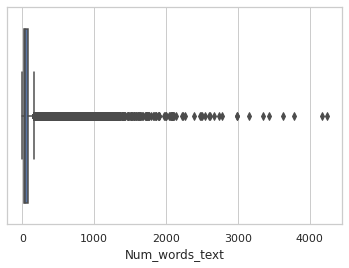

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

In [ ]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))


No of Short reviews
118480
No of Long reviews
36358


In [ ]:

print(df_short_reviews['Num_words_text'].max())


99


In [ ]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0
    

In [ ]:
#df_short_reviews['rating'].value_counts()
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())


60326
5.0    34658
4.0    11857
3.0     6442
1.0     4080
2.0     3289
Name: rating, dtype: int64
Train data
1    52957
0     7369
Name: sentiment, dtype: int64
122502
5.0    71047
4.0    23187
3.0    13118
1.0     8574
2.0     6576
Name: rating, dtype: int64
Test data
1    107352
0     15150
Name: sentiment, dtype: int64


In [ ]:
train_data['sentiment'].value_counts()

1    52957
0     7369
Name: sentiment, dtype: int64

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.5,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:30163
Class distributionCounter({1: 26479, 0: 3684})
Valid data len:30163
Class distributionCounter({1: 26478, 0: 3685})


In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))


[[1, 121, 20, 13]]


In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

Train data len:30163
Class distributionCounter({1: 26479, 0: 3684})
Validation data len:30163
Class distributionCounter({1: 26478, 0: 3685})
Test data len:122502
Class distributionCounter({1: 107352, 0: 15150})


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  


======Train dataset ====
tf.Tensor(
[   66    34   174    10     4    14  1245   614     2    72    14   644
   296   135   170    37   160    30    22    31  9058   151   346   488
    76    13    95     3   877     2   903 12574   966   296    14   687
    31     2  7483     3   759   339     2   135   615   749    60     8
   803   251    60     3  1358    53  9059   614  1424     4     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[ 4685    38   317  1868     1    46    91     1  1272   706     3 14124
     1  1261    13  3007     3   942     9  1272     5   121    65    46
    13    11     1   164     2     6  2554     1   159   893    59  2988
   370     1   114   709    71

In [ ]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

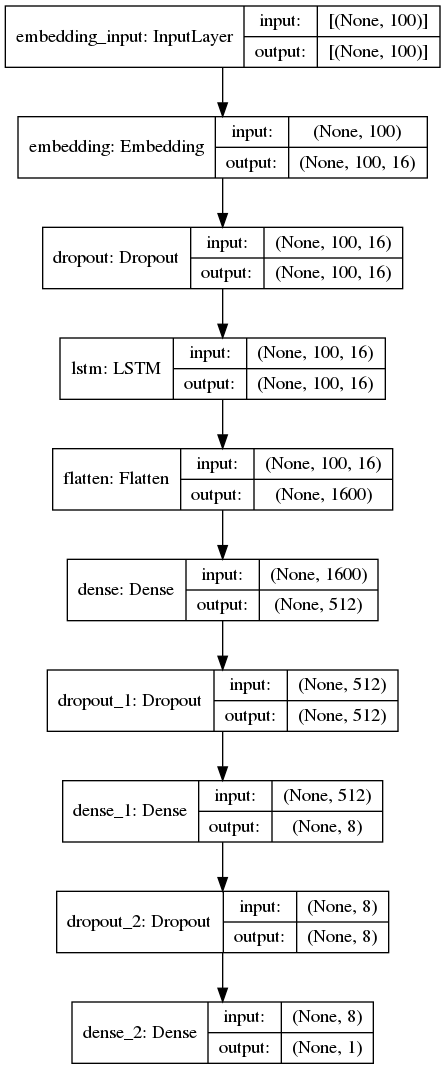

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 15s 305ms/step - loss: 2.5817 - binary_accuracy: 0.8671 - val_loss: 1.0398 - val_binary_accuracy: 0.8778
Epoch 2/10
30/30 [==============================] - 11s 358ms/step - loss: 0.7508 - binary_accuracy: 0.8779 - val_loss: 0.5564 - val_binary_accuracy: 0.8778
Epoch 3/10
30/30 [==============================] - 10s 328ms/step - loss: 0.5434 - binary_accuracy: 0.8779 - val_loss: 0.4741 - val_binary_accuracy: 0.8778
Epoch 4/10
30/30 [==============================] - 9s 314ms/step - loss: 0.4605 - binary_accuracy: 0.8779 - val_loss: 0.4080 - val_binary_accuracy: 0.8778
Epoch 5/10
30/30 [==============================] - 10s 347ms/step - loss: 0.4130 - binary_accuracy: 0.8779 - val_loss: 0.3876 - val_binary_accuracy: 0.8778
Epoch 6/10
30/30 [==============================] - 11s 379ms/step - loss: 0.3897 - binary_accuracy: 0.8779 - val_loss: 0.3717 - val_binary_accuracy: 0.8778
Epoch 7/10
30/30 [==============================] - 11s 376

In [ ]:
history.history

{'loss': [2.581679105758667,
  0.7507932186126709,
  0.5434052348136902,
  0.46046507358551025,
  0.4129764437675476,
  0.38974589109420776,
  0.37380459904670715,
  0.36132851243019104,
  0.3566320836544037,
  0.34697043895721436],
 'binary_accuracy': [0.8670556545257568,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441,
  0.8778635859489441],
 'val_loss': [1.0398060083389282,
  0.5564397573471069,
  0.4741455912590027,
  0.4079613983631134,
  0.38763871788978577,
  0.37174537777900696,
  0.35977691411972046,
  0.3550492525100708,
  0.3512172996997833,
  0.34740206599235535],
 'val_binary_accuracy': [0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449,
  0.877830445766449]}

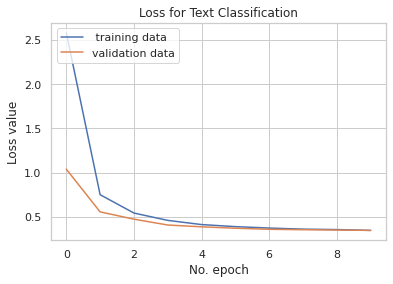

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

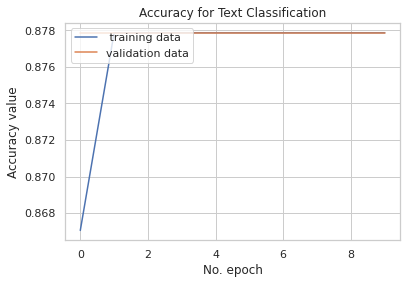

In [ ]:
plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [ ]:
model.save('tf_lstmmodel.h5') 
json_string = tokenizer.to_json()

In [ ]:
import json
with open('tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [ ]:
valid_predict= model.predict(x_valid)

In [ ]:
print(valid_predict[:10])

[[0.9999331 ]
 [0.99999964]
 [0.99990165]
 [0.9810755 ]
 [0.97717035]
 [0.987761  ]
 [0.5108061 ]
 [0.9999985 ]
 [0.9965602 ]
 [0.5494236 ]]


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

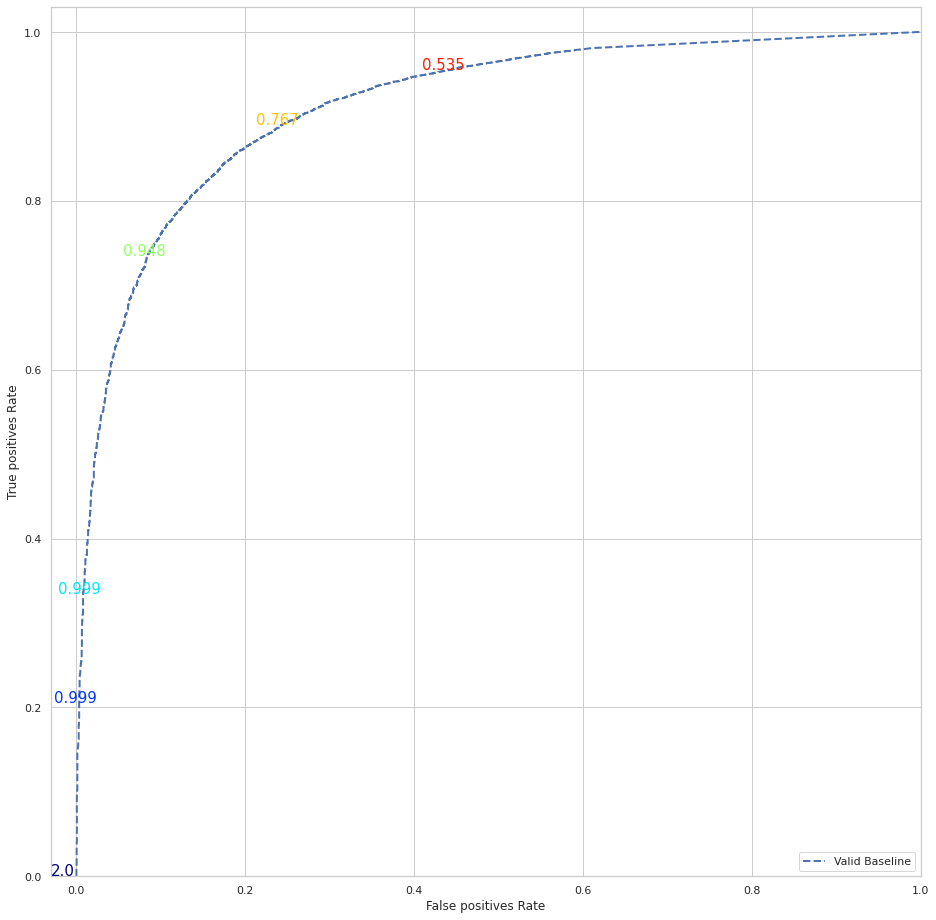

In [ ]:

plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
new_model = tf.keras.models.load_model('tf_lstmmodel.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [ ]:
with open('tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)


In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)

Generate predictions for all samples


In [ ]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.78),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.78),0,test_data.pred_sentiment)

/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/thriveni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.51      0.80      0.63     15150
           1       0.97      0.89      0.93    107352

    accuracy                           0.88    122502
   macro avg       0.74      0.85      0.78    122502
weighted avg       0.91      0.88      0.89    122502

